In [1]:
import os
import gc
import glob
import numpy as np
import random
import shutil
import warnings
import scipy.signal as sg
from collections import deque
from matplotlib import pyplot as plt
#from parallel_process import mp_map

import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Add, BatchNormalization
from tensorflow.python.keras.optimizers import Adam, Nadam
from tensorflow.python.keras.models import load_model
from tensorflow.contrib.keras import backend as K
tf.logging.set_verbosity(tf.logging.ERROR)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
seed = 42
root = '.'


def clean_checkpoints():
    try:
        shutil.rmtree('%s/checkpoints'%root)
    except Exception as ex:
        pass
    os.mkdir('%s/checkpoints'%root)

    try:
        shutil.rmtree('%s/tb_logs'%root)
    except Exception as ex:
        pass
    os.mkdir('%s/tb_logs'%root)

In [3]:
import traceback
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed


def mp_map(function, array, n_jobs=4, use_kwargs=False, front_num=1):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    # We run the first few iterations serially to catch bugs
    front = []
    out = []
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    # If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    # Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        # Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        # Print out the progress as tasks complete
        for future in tqdm(as_completed(futures), **kwargs):
            try:
                out.append(future.result())
            except Exception as e:
                print(e)
                traceback.print_exc()
                out.append(e)    
    return front + out

In [4]:
def translate_card(card_id):
    # lab, oachl, herz, schell
    if int(card_id) == 0:
        return 'None'
    colors = ['lab', 'oachl', 'herz', 'schell']
    hits = ['junge', 'dame', 'kinig', 'ass']
    color = colors[int(card_id+2)%4]
    hit = int(card_id+2)//4 + 6
    if hit < 11:
        return color + ' ' + str(hit)
    else:
        return color + ' ' + hits[hit-11]
    

class WattenEnv():
    
    def __init__(self, n_players=2, seed=42, debug=False):
        self.seed = seed
        self.debug = debug
        self.n_players = n_players
        self.played_cards = list(np.zeros(self.n_players*5, dtype=np.int))
        
    def __str__(self):
        ret_val = 'Cards: ' + str([[translate_card(j) for j in hand] for hand in self.player_cards]) + '\nStates: ' + str(self.states) + '\nActionSpace: ' + str(self.actions)
        return ret_val

    def close(self):
        pass

    def reset(self, player):
        """
        Reset environment and setup for new episode.
        Returns: initial state of reset environment.
        """
        self.turn = -self.n_players          # prepare for initial setup 'unsogn'
        self.deck = [i for i in range(1, 33+1)]
        random.shuffle(self.deck)
        self.hands = [self.deck[5*p:5*p+5] for p in range(self.n_players)]       # giving cards
        self.player_hands = self.hands
        #print(self.player_hands)
        self.played_cards = list()
        self.winners = list()
        self.price = 2        #value of win / loss
        self.schlog = None
        self.trumpf = None
        self.rechter = 0
        self.offered = False     # geboten player ID
        self.stings = [0,0]      # gemachte stiche pro team
        self.done = False        # counter until everybody got reward
        self.last_winner = 0
        return self.get_state(player)

    def choose_valid_card(self, player, orig_logits):
        if self.turn < 0 or self.turn % self.n_players == 0:
            return np.argmax(orig_logits[:len(self.player_hands[player])])
        else:
            first_card = self.played_cards[-(self.turn%self.n_players)]
            first_trumpf = (first_card+2)%4
        if first_trumpf == self.trumpf and player in [0, self.n_players-1]:
            logits = orig_logits.copy()
            logits[(logits+2)%4 == self.trumpf] -= 10000
            return np.argmax(logits[:len(self.player_hands[player])])
        else:
            return np.argmax(orig_logits[:len(self.player_hands[player])])
    
    def rank_card(self, card):
        farbe = (card+2)%4
        trumpf = farbe == self.trumpf
        schlog = ((card+2)//4 + 6) == self.schlog
        rechter = trumpf and schlog
        guater = trumpf and (((card+2)//4 + 6) == self.schlog+1 or (self.schlog == 14 and schlog == 7-(farbe==3)))
        return card, farbe, trumpf, schlog, rechter, guater
        
    def validate_sting(self, cards):
        best_card = None
        for card in cards:
            if best_card is None:
                best_card, best_farbe, best_trumpf, best_schlog, best_rechter, best_guater = self.rank_card(card)
                if best_guater:
                    break
            else:
                card, farbe, trumpf, schlog, rechter, guater = self.rank_card(card)
                if guater:
                    best_card, best_farbe, best_trumpf, best_schlog, best_rechter, best_guater = card, farbe, trumpf, schlog, rechter, guater
                    break
                elif rechter and not best_guater:
                    best_card, best_farbe, best_trumpf, best_schlog, best_rechter, best_guater = card, farbe, trumpf, schlog, rechter, guater
                elif schlog and not (best_schlog or best_rechter or best_guater):
                    best_card, best_farbe, best_trumpf, best_schlog, best_rechter, best_guater = card, farbe, trumpf, schlog, rechter, guater
                elif (trumpf or card == 1) and not (best_trumpf and ((card+2)//4 + 6) < ((best_card+2)//4 + 6)) and not (best_schlog or best_rechter or best_guater):
                    best_card, best_farbe, best_trumpf, best_schlog, best_rechter, best_guater = card, farbe, trumpf, schlog, rechter, guater
                elif (card+2)%4 == (best_card+2)%4 and ((card+2)//4 + 6 > (best_card+2)//4 + 6) and not (best_schlog or best_rechter or best_guater):
                    best_card, best_farbe, best_trumpf, best_schlog, best_rechter, best_guater = card, farbe, trumpf, schlog, rechter, guater
        return cards.index(best_card)
    
    def step(self, action, player):
#         if self.debug:
#             print(action)
        team = self.turn % 2
        go = np.argmax(action[-2:])
        offer = np.argmax(action[-4:-2])
        hold = self.choose_valid_card(player, action[:5])
        chosen_action = np.zeros(9)
        chosen_action[np.array([hold, 5 + offer, 7 + go])] = 1
        if self.debug and (self.turn == -self.n_players or self.turn == -1  or self.turn >= 0 or go or offer):
            message = 'Player ' + str(player)
            if (self.turn == -self.n_players or self.turn == -1  or self.turn >= 0):
                if self.turn < 0:
                    message += ' sog un'
                else:
                    message += ' wirft'
                message += ': ' + translate_card(self.player_hands[player][hold])
            if offer:
                if (self.turn == -self.n_players or self.turn == -1  or self.turn >= 0):
                    message += ' und'
                message += ' biatet ' + str(self.price + 1 + (self.offered>0))
            elif go:
                if (self.turn == -self.n_players or self.turn == -1  or self.turn >= 0):
                    message += ' und'
                message += ' will gian'
            print(message)
        
        if self.turn < 0:
            card_id = self.player_hands[player][hold]
            if self.turn == -self.n_players and self.schlog is None:
                self.schlog = (card_id+2)//4+6
            elif self.turn == -1 and self.trumpf is None:
                self.trumpf = (card_id+2)%4
                self.rechter = (self.schlog-6)*4 - 2 + self.trumpf
                if self.debug:
                    print('Ungsog:', translate_card(self.rechter), '\n')
        else:
            card_id = self.player_hands[player].pop(hold)
            self.played_cards.append(card_id)  
            
        if self.offered:
            if self.offered%2==1 and go:
                self.stings[(team+1)%2] = 3
                self.done = True
                self.last_winner = (team+1)%2
                self.offered = False
            elif offer:
                if self.offered:
                    self.price += 1
                    self.offered = True
            else:
                self.offered += 1
        elif offer:
            self.offered = True
        elif go:
            self.stings[(team+1)%2] = 3
            self.done = True
            self.last_winner = (team+1)%2
            
        if not self.done and self.offered >= self.n_players-1 or (self.turn+self.n_players)%self.n_players==self.n_players-1:
            self.price += 1
            self.offered = False
        
        if not self.done and self.turn > 0 and (self.turn) % self.n_players == self.n_players-1:
            self.last_winner = self.validate_sting(self.played_cards[-self.n_players:])
            self.winners.append(self.last_winner+1)
            self.stings[self.last_winner%2] += 1
            if self.debug:
                print('Stich mit korte ', self.last_winner+1, ',   Cards: ', [translate_card(c) for c in self.played_cards[-self.n_players:]], 'Stiche: ', self.stings, '\n')
        
        if self.done or 3 in self.stings:
            self.done = True
            rewards = [(s==3)*self.price or -(s!=3)*self.price for s in self.stings]*(self.n_players//2)
            if self.debug:
                print('Spiel vobei! Punkte:', rewards, 'Stiche:', self.stings, 'Geboten woren:', self.price, '\n\n')
        else:
            rewards = [0]*self.n_players

        self.turn += 1
        return self.get_state(player), [r/5 for r in rewards], chosen_action, self.done, self.last_winner
        
    def get_state(self, player):
        """
        player_state is composed of an array of length 28:
        for 4 players it looks as shown:
        1: rechter for players allowed to see it
        2: amount of offered points
        3: turn number
        4-9: player hand
        10-28: cards already played
        """
        player_state = np.array([self.rechter*((self.turn+4)%self.n_players in [0, self.n_players-1])/34] + 
                                [self.offered/25] + 
                                [self.turn/(5*self.n_players)] + 
                                [c/34 for c in self.player_hands[player]] + [0] * (5-len(self.player_hands[player])) + 
                                [c/34 for c in self.played_cards] + [0] * (self.n_players*5 - len(self.played_cards)) +
                                [w/(self.n_players+1) for w in self.winners] + [0] * (5 - len(self.winners))
                               )
        return np.expand_dims(np.array(player_state), axis=0)
        
    @property
    def observation_space(self):
        return np.array([0,0,0]+5*[0]+[0]*self.n_players*5+[0]*5)
    
    @property
    def action_space(self):
        hold = [0]*5
        offer = [0]*2
        go = [0]*2
        return np.expand_dims(np.array(hold + offer + go), axis=0)

In [ ]:
class CollectiveMemory:
    
    def __init__(self, memsize):
        self.size = memsize
        self._memories = deque(maxlen=memsize)
        
    def get(self,):
        return self._memories
    
    def append(self, mem):
        self._memories.append(mem)
        
    def resize(self, new_size):
        self.size = new_size
        self._memories = deque(self._memories, maxlen=self.size)

In [ ]:
class HumanPlayer:
       
    def __init__(self, env, name):
        self.env = env
        self.name = name
        
    def act(self, state):
        rechter = translate_card(state[0][0]*34)
        bet = state[0][1] > 0
        turn = state[0][2]*(5*self.env.n_players)
        played_cards = [True for s in state[0][8:] if s != 0]
        player = (len(played_cards)+1)%self.env.n_players
        hand = list(state[0][3:8])
        cards = ['%s: %s'%(i+1,translate_card(c*34)) for i,c in enumerate(hand) if c != 0]       # [translate_card(c*34) for c in hand if c != 0]
        if self.env.turn >= 0 or self.env.turn == -1 or self.env.turn == -self.env.n_players:
            if bet:
                geboten = '      Gebotn isch!'
            else:
                geboten = ''
            print('Deine Korten: %s                 Ungsog: %s%s'%(cards, rechter, geboten))

            choice = 0
            if bet:
                while choice not in [1,2,3]:
                    go = [0,0]
                    bet = [0,0]
                    choice = int(float(input('Hebn: 1      Gian: 2      Biatn: 3')))
                    go[choice == 2] = 1
                    bet[choice == 3] = 1
            else:
                while choice not in [1,3]:
                    bet = [0,0]
                    choice = int(float(input('Hebn: 1      Biatn: 3')))
                    go =[1,0]
                    bet[choice == 3] = 1
            if choice in [1,3]:
                card = None
                while card not in range(1,len(cards)+1):
                    try:
                        card = int(float(input('Wos wirfschn?')))
                    except Exception as ex:
                        pass
                chosen = [0]*5
                chosen[card-1] = 1
            else:
                chosen = [0]*5
               
            chosen = chosen + bet + go
        else:
            chosen = [0]*5 + [0,0] + [0,0]
                
        return np.array([chosen])

    def remember(self, state, action, reward, new_state, done):
        pass

    def replay(self):
        return 0
            
    def eval(self):
        return 0

    def target_train(self):
        pass

    def save_model(self, fn):
        pass

In [ ]:
class DQN:
       
    def __init__(self, env, name, memory, rounds, restore=None, neurons=256, res_blocks=5, alpha=1.0):
        self.env = env
        self.neurons = neurons
        self.res_blocks = res_blocks
        self.alpha = alpha
        self.name = name
        self.memory = memory
        
        '''
        self.gamma = 0.9
        self.epsilon = 0.2
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.0051
        self.tau = .125
        '''
        
        self.gamma = 0.9                     # discount for future rewards 
        self.epsilon = 0.4                   # probability of a random action
        self.epsilon_min = 0.01              # min epsilon
        self.epsilon_decay = 0.99           # rate of decay for epsilon
        self.learning_rate = 0.0001
        self.tau = .125
        
        self.model = self.create_model(restore)
        self.target_model = self.create_model(restore)
        self.batch_size = 350
        
    

    def create_model(self, restore):
        
        def res_block(x, n):
            x1 = Dense(int(n*self.alpha), activation='relu')(x)
            x1 = BatchNormalization()(x1)
            x2 = Dense(n, activation='relu')(x1)
            x2 = BatchNormalization()(x2)
            
            x = Add()([x, x2])
            return x
        
        if restore is None:
            inputs = Input((self.env.observation_space.size,), name='main_input')
            x = Dense(self.neurons, activation='relu')(inputs)
            x = res_block(x, self.neurons)
            for rb in range(self.res_blocks-1):
                x = res_block(x, self.neurons)
            predictions = Dense(self.env.action_space.size, activation='softmax')(x)
            
            model = Model(inputs=inputs, outputs=predictions)
            model.compile(loss='mse',
                optimizer=Nadam(lr=self.learning_rate))
        else:
            model = load_model(restore)
            
        return model

    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if train:
            if np.random.random() < self.epsilon:
                return np.random.normal(0, 0.1, self.env.action_space.shape)
        return self.model.predict(state)

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        if len(self.memory.get()) < self.batch_size: 
            return None

        samples = random.sample(self.memory.get(), self.batch_size)
        states = []
        actions = []
        rewards = []
        new_states = []
        dones = []
        for sample in samples:
            '''
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)
            '''
            state, action, reward, new_state, done = sample
            states.append(state)
            actions.append(action)
            rewards.append(reward/25)
            new_states.append(new_state)
            dones.append(done)
        targets = self.target_model.predict_on_batch(np.concatenate(states))
        Q_futures = [max(fut) for fut in self.target_model.predict_on_batch(np.concatenate(new_states))]
        for i, target in enumerate(targets):
            for j, action in enumerate(actions[i]):
                if dones[i]:
                    if action:
                        targets[i][j] = rewards[i]
                else:
                    targets[i][j] = rewards[i] + Q_futures[i] * self.gamma
        loss = (self.model.train_on_batch(np.concatenate(states), targets))
        return loss
            
    
    def eval(self):
        if len(self.memory.get()) < self.batch_size: 
            return None
        
        mse = []
        for s in range(len(self.memory.get())//self.batch_size):
            samples = random.sample(self.memory.get(), self.batch_size)
            states = []
            actions = []
            rewards = []
            new_states = []
            dones = []
            for sample in samples:
                state, action, reward, new_state, done = sample
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                new_states.append(new_state)
                dones.append(done)
            targets = self.target_model.predict_on_batch(np.concatenate(states))
            Q_futures = [max(fut) for fut in self.target_model.predict_on_batch(np.concatenate(new_states))]
            for i, target in enumerate(targets):
                for j, action in enumerate(actions[i]):
                    if dones[i]:
                        if action:
                            targets[i][j] = rewards[i]
                    else:
                        targets[i][j] = rewards[i] + Q_futures[i] * self.gamma
            mse.append(self.model.test_on_batch(np.concatenate(states), targets))
        return sum(mse)/len(mse)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save(fn)

In [ ]:
def match(trial_id, env, agents, trials, metric='points', show_progress=False):

    if metric not in ['points', 'loss']:
        raise Exception('unsupported metric')

    trial_len = 5
    n_players=len(agents)
    random_order = [i for i in range(n_players)]
    # random.shuffle(random_order)
    all_points = []
    all_losses = []
    offset = trial_id
    order = [random_order[((offset + i)%n_players)] for i in range(n_players)]
    for trial in range(trials):
        np.random.shuffle(order)
        cur_state = env.reset(order[0])
        winner = 0
        round_done = False
        while not round_done:
            states = [cur_state]
            actions = []
            rewards = []
            losses = [1 for i in range(n_players)]
            # agents = [agents[(step + i)%n_players] for i in range(n_players)]
            # print('')
            order = [order[((winner + i)%n_players)] for i in range(n_players)]
            # env.player_hands = [env.player_hands[order[i]] for i in range(n_players)]
            completed_rounds = 0
            for i, player in enumerate(order):
                agent = agents[player]
                cur_state = env.get_state(player)
                action = agent[0].act(cur_state)[0]
                new_state, reward, action, round_done, winner = env.step(action, player)
                actions.append(action)
                states.append(new_state)
                rewards.append(reward)
                completed_rounds += 1
                if round_done:
                    for o, j in enumerate(order):
                        agents[j][1] += int(reward[o]*5)
                    break
            for o, i in enumerate(order):
                agent = agents[i]
                if i < completed_rounds:      # prevents trying to add memories for agents that have none
                    agent[0].remember(states[i], actions[i], rewards[-1][i], new_state, round_done)
                loss = agent[0].replay()       # internally iterates default (prediction) model
                agent[0].target_train()        # iterates target model
                losses[i] = loss
                #cur_state = new_state
            if round_done:
                if losses[0] == 1:
                    for agent in agents:
                        agent[1] = 0
                points = [agent[1] for agent in agents]
                all_points.append(points)
                all_losses.append(losses)
                offset += 1
                if show_progress and train:
                    points_string = 'Points: %s'%points
                    losses_string = '   Losses: %s'%losses
                    percent_string = str(10000*(trial+1)//trials/100)+'%'
                    print('\r' + percent_string + ' '*max(0,7-len(percent_string)) + points_string + 
                          ' '*max(0, (35-len(points_string))) + losses_string, end='')

    # print('\r', end='')
    losses = []
    for agent in agents:
        loss = agent[0].eval()
        agent.append(loss)
        losses.append(loss)
    # print(losses)
    if metric == 'points':
        best_agents = sorted(agents, key=lambda x: x[1], reverse=True)
    elif metric == 'loss':
        best_agents = sorted(agents, key=lambda x: x[-1])     # loss=x[-1])[:2]   points=x[1])[-2:]

    best_agent_names = []
    for agent in best_agents:
        agent_id = agent[2]
        agent_res_blocks = agent[3]
        agent_neurons = agent[4]
        agent_alpha = agent[5]
        agent_loss = agent[-1]
        agent_points = agent[1]
        # print('agent %s: \tres_blocks: %s \tneurons: %s \talpha: %s \tpoints: %s  \tloss: %s'%(agent_id, agent_res_blocks, agent_neurons, agent_alpha, agent_alpha, agent_points, agent_loss))
        agent_name = 'agent_%s_%s_%s_%s_%s_%s'%( trial_id, agent_id, agent_res_blocks, agent_neurons, int(agent_alpha*1000), agent_points)
        agent[0].name = agent_name
        best_agent_names.append('./checkpoints/%s.h5'%(agent_name))
    for i in range(n_players//2):
        best_agents[i][0].save_model(best_agent_names[i])
    # for agent in agents:
    #    agent[0].clear()

    all_losses = [[i if i is not None else 1 for i in loss] for loss in all_losses]

    plt.figure(figsize=(26, 10), facecolor='white')
    ax = plt.subplot(1, 2, 1)
    ax.set_title('Points')
    for i in random_order:
        plt.plot([p[i] for p in all_points], label='%s'%(agents[i][0].name))
    ax.legend(loc="upper left")
    ax = plt.subplot(1, 2, 2)
    ax.set_title('Lowpassed Losses')
    b, a = sg.butter(4, 1/(trials*max(0.005, 1/(trials-1))))
    plt.plot(sg.filtfilt(b, a, all_losses, axis=0))
    #plt.plot(all_losses)
    plt.tight_layout()
    plt.show()

    # print()
    return best_agent_names[:n_players//2]

In [ ]:
def first_matches(args):

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    K.set_session(sess)

    collective_memory = args[1]
    n_players = args[2]
    trials = args[3]
    metric = args[4]
    trial_id = args[5]
    env = WattenEnv(n_players=n_players, debug=not train)

    agent_attrs = []
    for i in range(n_players):
        layers = random.randint(3,9)
        neurons = 2**random.randint(8,11)
        alpha = random.choice([0.7, 0.9, 1.0])
        agent_attrs.append([layers, neurons, alpha])
    agents = [[DQN(env=env,                                                     # DQN-agent
                   res_blocks=agent_attrs[p][0], 
                   neurons=agent_attrs[p][1],
                   alpha=agent_attrs[p][2],
                   name='agent_%s'%(trial_id*n_players+p), 
                   memory=collective_memory, 
                   rounds=trial_id
                  ),
               0,                                                               # Points
               trial_id*n_players+p,                                          # Agent-ID
               agent_attrs[p][0],                                               # Residual Blocks
               agent_attrs[p][1],                                               # Neurons
               agent_attrs[p][2]                                                # Alpha
              ] for p in range(n_players)]
    
    match_best_agents = match(trial_id, env, agents, trials, metric=metric, show_progress=(workers==1))
    K.clear_session()
    return match_best_agents


def next_matches(args):
    
    # print('\nRound', i+1)
    # collective_memory, n_players, trials, metric, trial_id, i, old_agents

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    K.set_session(sess)
    
    collective_memory = args[0]
    n_players = args[1]
    trials = args[2]
    metric = args[3]
    trial_id = args[4]
    match_id = args[5]
    old_agents = args[6]
    env = WattenEnv(n_players=n_players, debug=not train)

    agent_names = old_agents[match_id*n_players: match_id*n_players+n_players]
    agents = []
    for a in agent_names:
        if not a.startswith('Player'):
            splits = a.split('/')[-1].split('_')
            # 'checkpoints/%s_%s_%s_%s_%.4f_%s.h5'%( trial_id, agent_id, agent_res_blocks, agent_neurons, agent_alpha, agent_points)
            p_id = int(float(splits[2]))
            layers = int(float(splits[3]))
            neurons = int(float(splits[4]))
            alpha = float(splits[5])/1000
            agents.append([DQN(env, name='agent_%s'%(p_id), 
                               memory=collective_memory, 
                               rounds=trial_id, 
                               restore=a, 
                               neurons=neurons, 
                               res_blocks=layers,
                               alpha=alpha
                              ), 
                           0, 
                           p_id, 
                           layers, 
                           neurons,
                           alpha
                          ]
                         )
        else:
            agents.append([HumanPlayer(env, a),
                          0,
                          a,
                          'inf',
                          'inf',
                          1.0
                          ]
                         )
    match_best_agents = match(trial_id, env, agents, trials, metric=metric, show_progress=(not train or workers==1))
    K.clear_session()
    return match_best_agents

In [ ]:
def main():
    global workers, max_workers
    n_players = 4
    humans = 1
    trial_id = 0
    
    if not train:
        max_workers = 1
    print('Running on max %s processes.\n'%max_workers)
    
    first_trials = 2**3
    trials = 2000
    memsize = 20000
    if train:
        best_agents = glob.glob('%s/checkpoints/*.h5'%root)
    else:
        best_agents = ['Player_%s'%i for i in range(humans)]
        best_agents = best_agents + glob.glob('./saved/*.h5')[:n_players-humans]
    
    metric = 'points'     # 'loss'    'points'
    
    collective_memory = CollectiveMemory(memsize)
    args = []
    if train:
        clean = None
        while clean not in ['y', 'Y', '', 'n', 'N']:
            clean = input('Do you want to delete all checkpoints and train from scratch? Y/n')
            if clean in ['y', 'Y', '']:
                clean_checkpoints()
                best_agents = []

        if clean in ['y', 'Y', '', None]:
            for t in range(first_trials):
                args.append([None, collective_memory, n_players, trials, metric, trial_id])
            workers = min(len(args), max_workers)
            if workers > 1:
                winners = mp_map(first_matches, args, n_jobs=workers, front_num=0)
            else:
                winners = [first_matches(arg) for arg in args]
            for w in winners:
                best_agents += w
    
    print('Best Agents:')
    for agent in best_agents:
        print(agent)
    print('\n')
    
    try:
        while True:
            while len(best_agents) < n_players:
                best_agents = best_agents * 2      # n_players
            old_agents = best_agents
            random.shuffle(old_agents)
            best_agents = []
            trial_id += 1
            # trials *= 2
            trials += 1000
            collective_memory.resize(int(collective_memory.size*1.2))
            args = []
            for i in range(len(old_agents)//n_players):
                args.append([collective_memory, n_players, trials, metric, trial_id, i, old_agents])
            workers = min(len(args), max_workers)
            if workers > 1:
                winners = mp_map(next_matches, args, n_jobs=workers, front_num=0)
            else:
                winners = [next_matches(arg) for arg in args]
            for w in winners:
                best_agents += w

            print('Best Agents:')
            for agent in best_agents:
                print(agent)
            print('\n')
    except KeyboardInterrupt as kix:
        print('\n\nTraining stopped.')
        
    print('Done.')    

Running on max 4 processes.



Do you want to delete all checkpoints and train from scratch? Y/n y


  0%|          | 0.00/8.00 [00:00<?, ?it/s]/home/raf/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


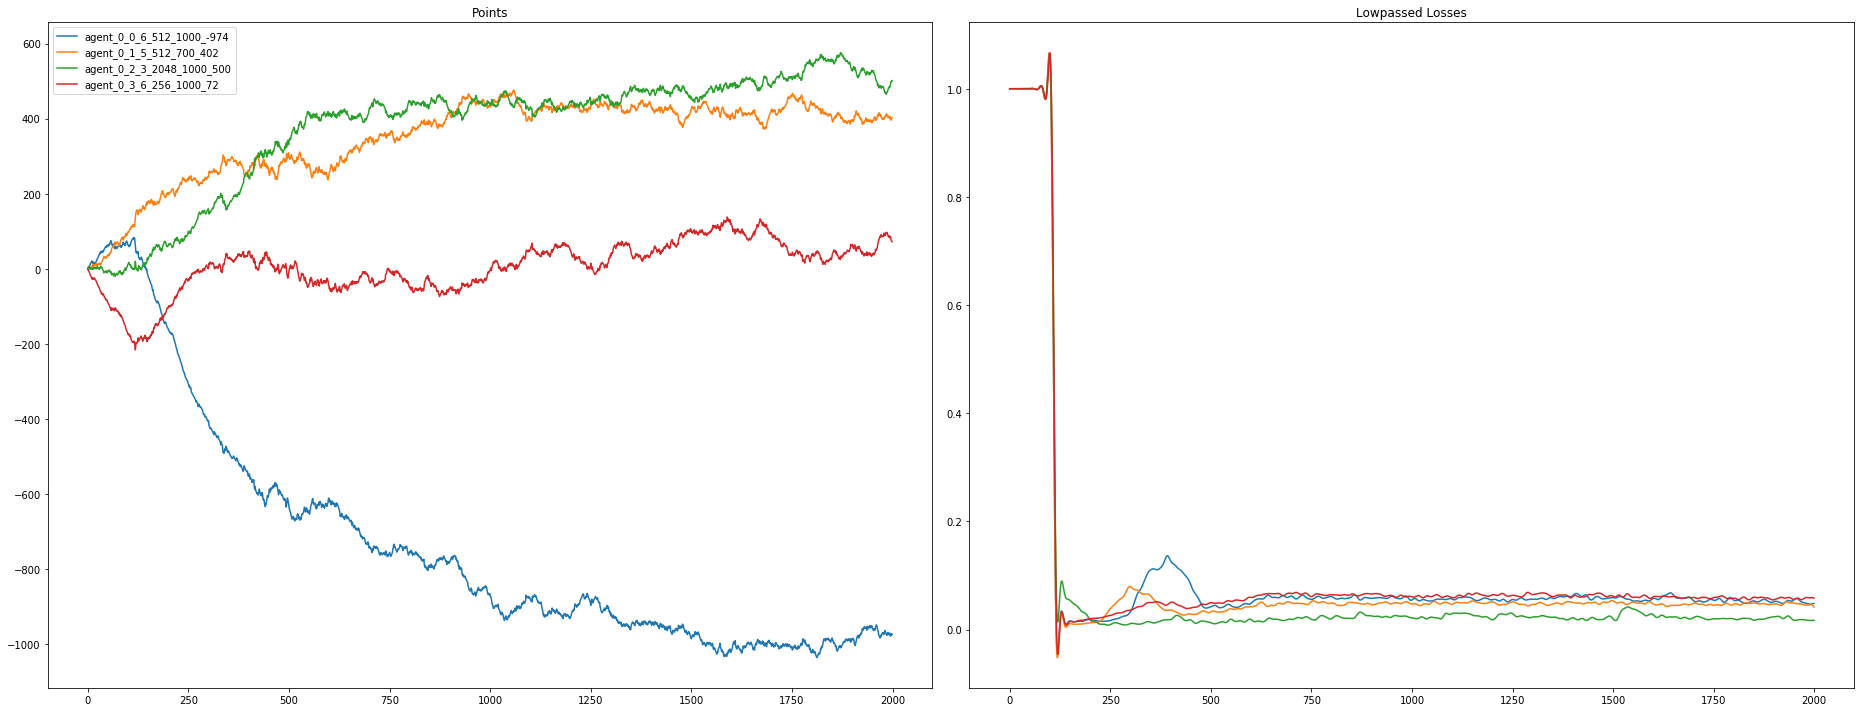

 12%|█▎        | 1.00/8.00 [44:55<5:14:28, 2.70ks/it]/home/raf/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


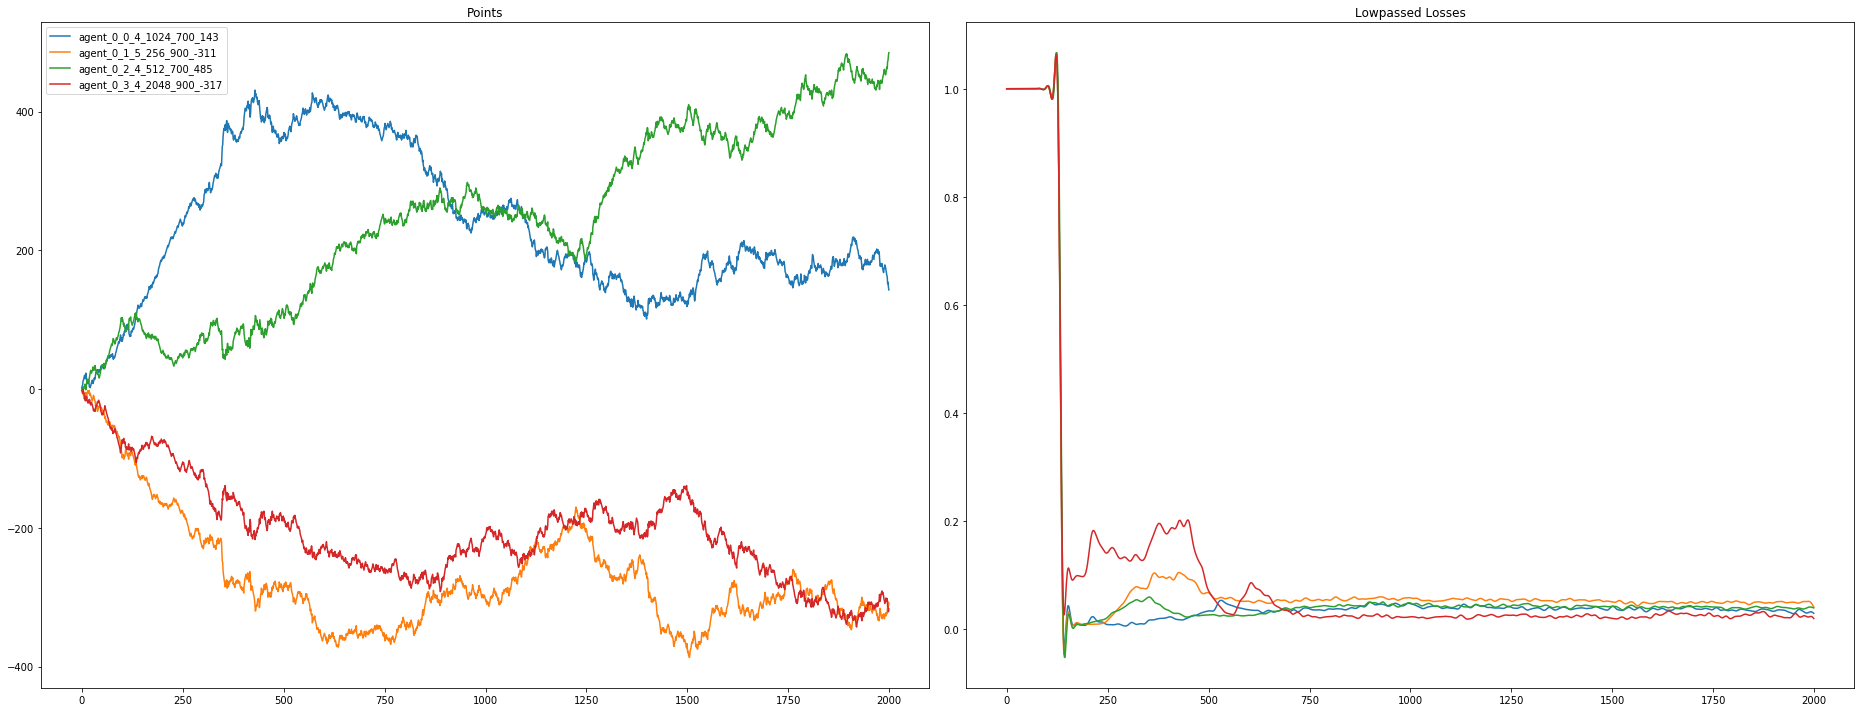

 25%|██▌       | 2.00/8.00 [46:13<3:11:01, 1.91ks/it]/home/raf/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


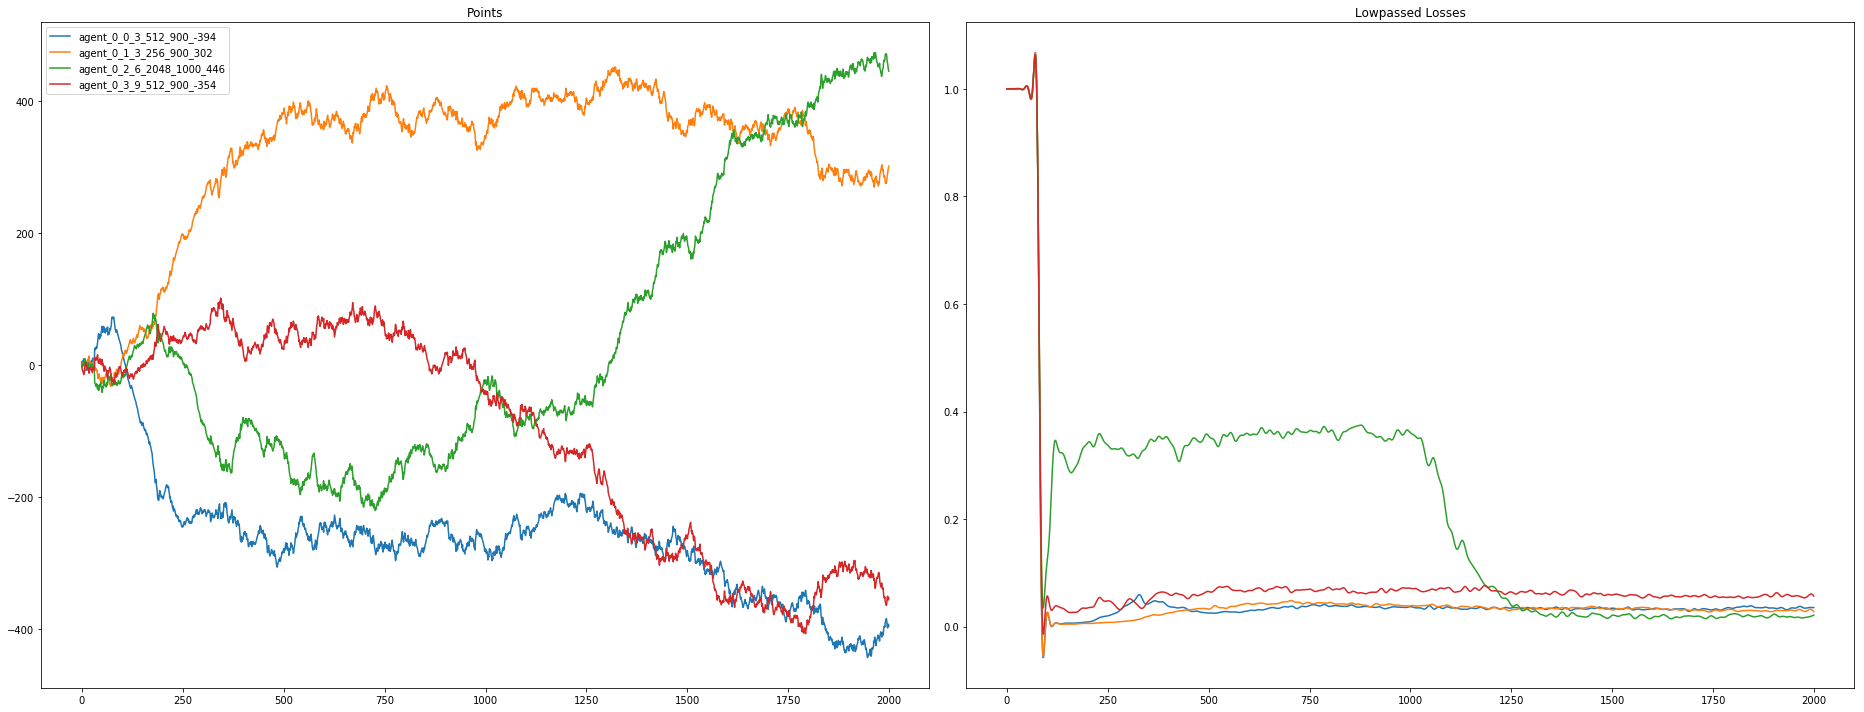

 38%|███▊      | 3.00/8.00 [1:03:52<2:17:54, 1.65ks/it]/home/raf/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


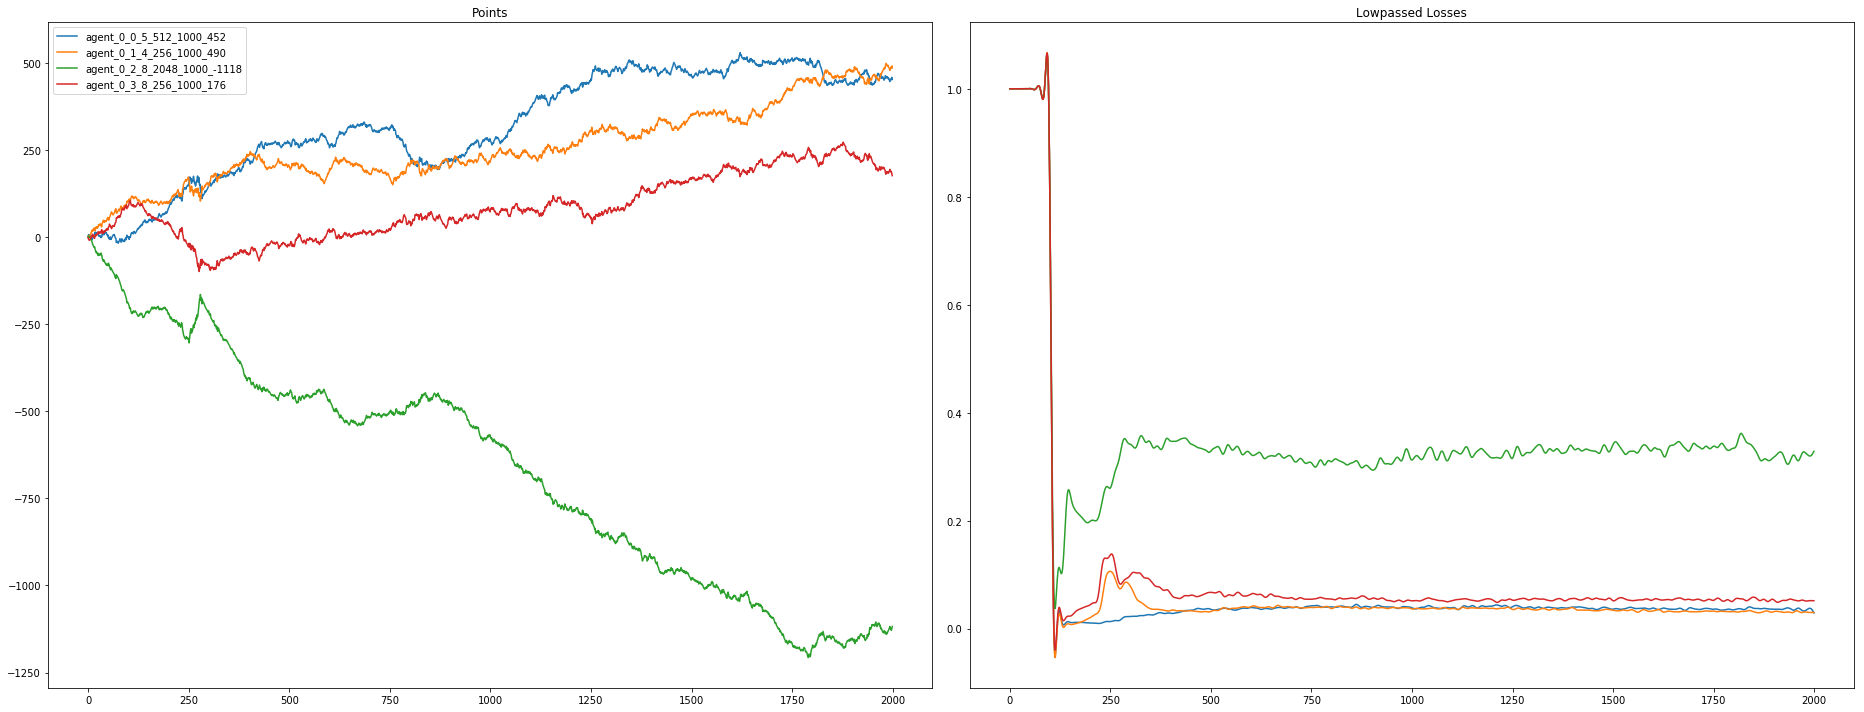

 50%|█████     | 4.00/8.00 [1:08:18<1:22:33, 1.24ks/it]

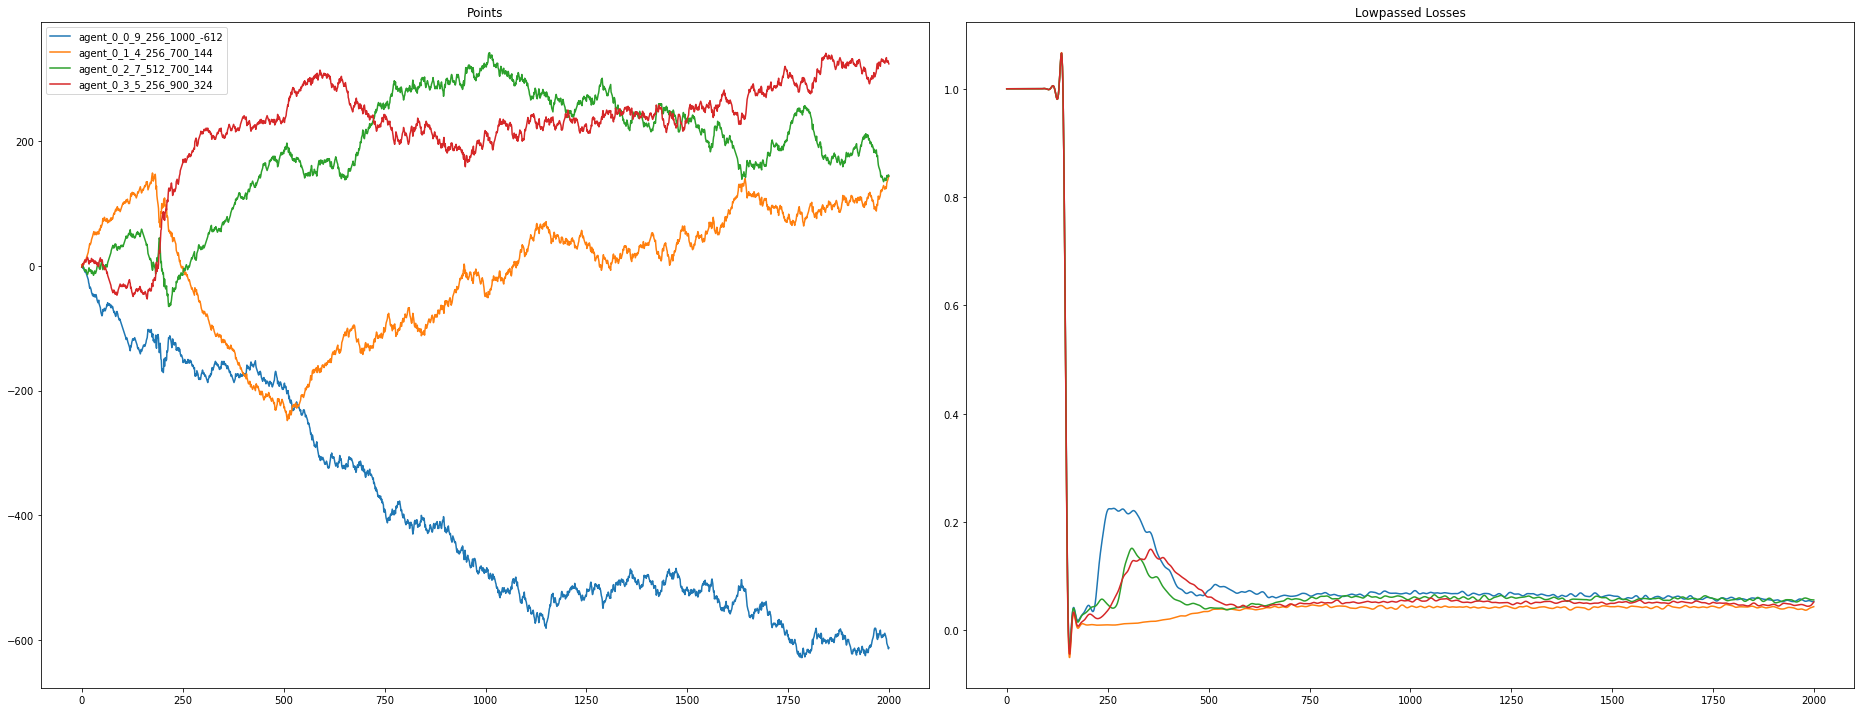

 62%|██████▎   | 5.00/8.00 [1:30:32<1:03:20, 1.27ks/it]

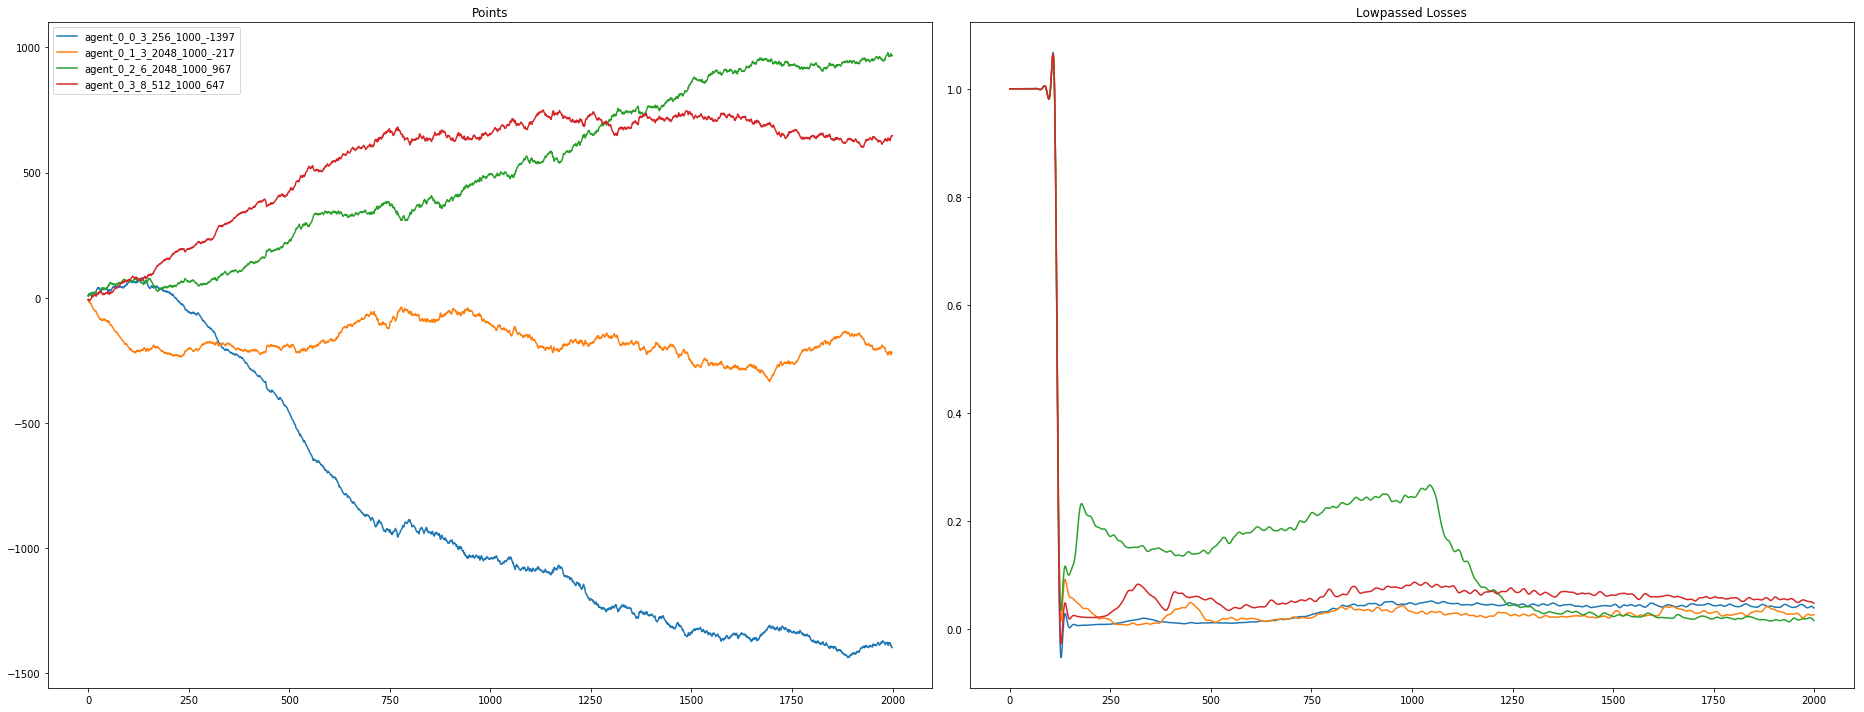

 75%|███████▌  | 6.00/8.00 [1:48:19<40:14, 1.21ks/it]  

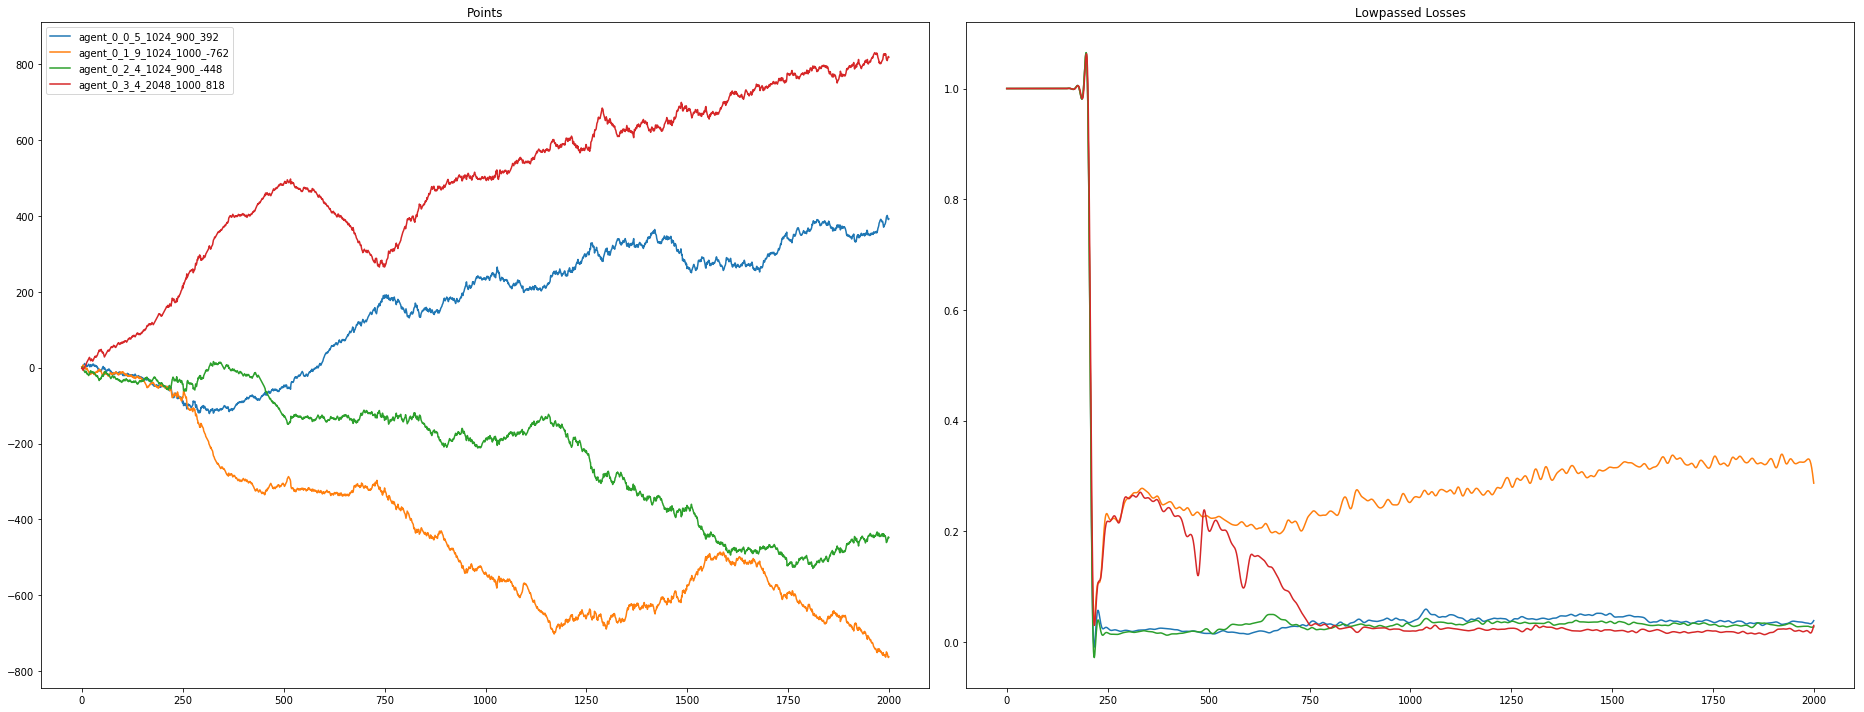

 88%|████████▊ | 7.00/8.00 [1:48:53<14:14, 855s/it]  

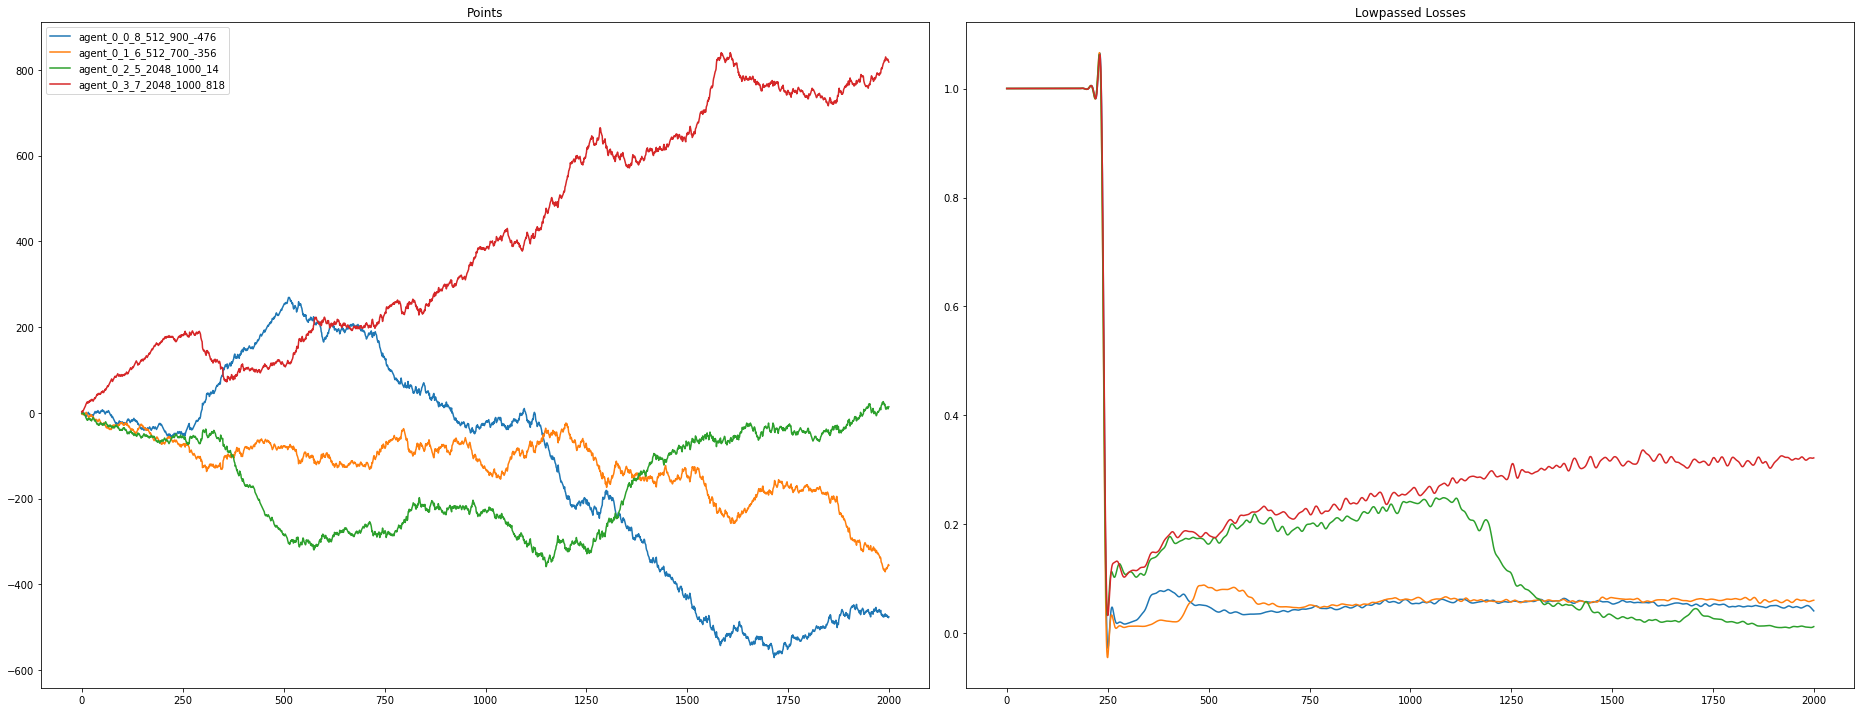

100%|██████████| 8.00/8.00 [2:01:11<00:00, 820s/it]


Best Agents:
./checkpoints/agent_0_2_3_2048_1000_500.h5
./checkpoints/agent_0_1_5_512_700_402.h5
./checkpoints/agent_0_2_4_512_700_485.h5
./checkpoints/agent_0_0_4_1024_700_143.h5
./checkpoints/agent_0_2_6_2048_1000_446.h5
./checkpoints/agent_0_1_3_256_900_302.h5
./checkpoints/agent_0_1_4_256_1000_490.h5
./checkpoints/agent_0_0_5_512_1000_452.h5
./checkpoints/agent_0_3_5_256_900_324.h5
./checkpoints/agent_0_1_4_256_700_144.h5
./checkpoints/agent_0_2_6_2048_1000_967.h5
./checkpoints/agent_0_3_8_512_1000_647.h5
./checkpoints/agent_0_3_4_2048_1000_818.h5
./checkpoints/agent_0_0_5_1024_900_392.h5
./checkpoints/agent_0_3_7_2048_1000_818.h5
./checkpoints/agent_0_2_5_2048_1000_14.h5




  0%|          | 0.00/4.00 [00:00<?, ?it/s]

In [ ]:
train = True
max_workers = 4

main()

In [ ]:
train = False

main()